<a href="https://colab.research.google.com/github/Polineska/Sentiment-reviews/blob/main/GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
file_path = 'data (1).xlsx'
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)

['подсчет', 'нетоксик_1_Лиза_1', 'нетоксик_1_АЩ_2', 'нетоксик_2_ПОЛЯНА_1', 'нетоксик_2_егор_2', 'токсик_1_ПОЛЯНА_1', 'токсик_1_егор_2', 'токсик_2_Вася_1', 'токсик_2_егор_2']


In [ ]:
df_list = [xls.parse(sheet) for sheet in xls.sheet_names]
df = pd.concat(df_list, ignore_index=True)
print("Столбцы в датасете:", df.columns)

Столбцы в датасете: Index(['Unnamed: 0', 'сумма', 'токсик_1_ПОЛЯНА_1', 'токсик_2_Вася_1',
       'нетоксик_1_Лиза_1', 'нетоксик_2_ПОЛЯНА_1', 'разметка', 'текст',
       'контекст', 'Unnamed: 3', 'type', 'amount'],
      dtype='object')


In [ ]:
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = ''.join([ch for ch in text if ch.isalnum() or ch.isspace()])
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    else:
        text = ""
    return text

df['cleaned_comment'] = df['текст'].apply(preprocess_text)
df['разметка'] = df['разметка'].replace({'neg': 'negative', 'neutal': 'neutral'})
df = df.dropna(subset=['разметка'])
print("Уникальные метки в 'разметка':", df['разметка'].unique())

Уникальные метки в 'разметка': ['speech' 'positive' 'negative' 'neutral' 'skip']


In [ ]:
X = df['cleaned_comment']
y = df['разметка']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression())
])
param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear', 'saga']}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
target_names = [str(cls) for cls in label_encoder.classes_]

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Точность на тестовых данных: {grid_search.best_score_}")
print("\nКлассификационный отчет:\n", classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names))


Лучшие параметры: {'clf__C': 10, 'clf__solver': 'saga'}
Точность на тестовых данных: 0.7593172119487909

Классификационный отчет:
               precision    recall  f1-score   support

    negative       0.65      0.46      0.54       283
     neutral       0.44      0.30      0.35       286
    positive       0.71      0.44      0.54       244
        skip       0.78      0.92      0.84      1708
      speech       0.87      0.62      0.72       116

    accuracy                           0.74      2637
   macro avg       0.69      0.55      0.60      2637
weighted avg       0.73      0.74      0.72      2637



In [ ]:
import joblib
joblib.dump(grid_search.best_estimator_, 'model.joblib')
joblib.dump(grid_search.best_params_, 'model_params.joblib')

['model_params.joblib']

In [ ]:
model = joblib.load('model.joblib')

test_file_path = 'Test_data.xlsx'
test_xls = pd.ExcelFile(test_file_path)

print(test_xls.sheet_names)

['подсчет', 'нетоксик_1_Лиза_1', 'нетоксик_1_АЩ_2', 'нетоксик_2_ПОЛЯНА_1', 'нетоксик_2_егор_2', 'токсик_1_ПОЛЯНА_1', 'токсик_1_егор_2', 'токсик_2_Вася_1', 'токсик_2_егор_2']


In [ ]:
test_df_list = [test_xls.parse(sheet) for sheet in test_xls.sheet_names]
test_df = pd.concat(test_df_list, ignore_index=True)
test_df = test_df.dropna(subset=['разметка'])
test_df['разметка'] = test_df['разметка'].replace({'ne': 'neutral'})

In [ ]:
valid_labels = label_encoder.classes_
test_df = test_df[test_df['разметка'].isin(valid_labels)]

In [ ]:
test_df['cleaned_comment'] = test_df['текст'].apply(preprocess_text)

test_X = test_df['cleaned_comment']
test_y_pred = model.predict(test_X)
test_y_pred_labels = label_encoder.inverse_transform(test_y_pred)
test_y_true = test_df['разметка']
test_y_true_encoded = label_encoder.transform(test_y_true)

accuracy = accuracy_score(test_y_true_encoded, test_y_pred)
print(f"Точность модели на тестовых данных: {accuracy:.4f}")

target_names = label_encoder.classes_
print("\nКлассификационный отчет:\n", classification_report(test_y_true_encoded, test_y_pred, target_names=target_names))

Точность модели на тестовых данных: 0.8777

Классификационный отчет:
               precision    recall  f1-score   support

    negative       0.86      0.71      0.78      1280
     neutral       0.79      0.60      0.68      1166
    positive       0.86      0.65      0.74      1054
        skip       0.89      0.97      0.93      8698
      speech       0.94      0.80      0.86       545

    accuracy                           0.88     12743
   macro avg       0.87      0.75      0.80     12743
weighted avg       0.88      0.88      0.87     12743



<ipython-input-13-9b27bdb655cb>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y=report_df['precision'], ax=axes[0], palette='Blues')
<ipython-input-13-9b27bdb655cb>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y=report_df['recall'], ax=axes[1], palette='Greens')
<ipython-input-13-9b27bdb655cb>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y=report_df['f1-score'], ax=axes[2], palette='Oranges')


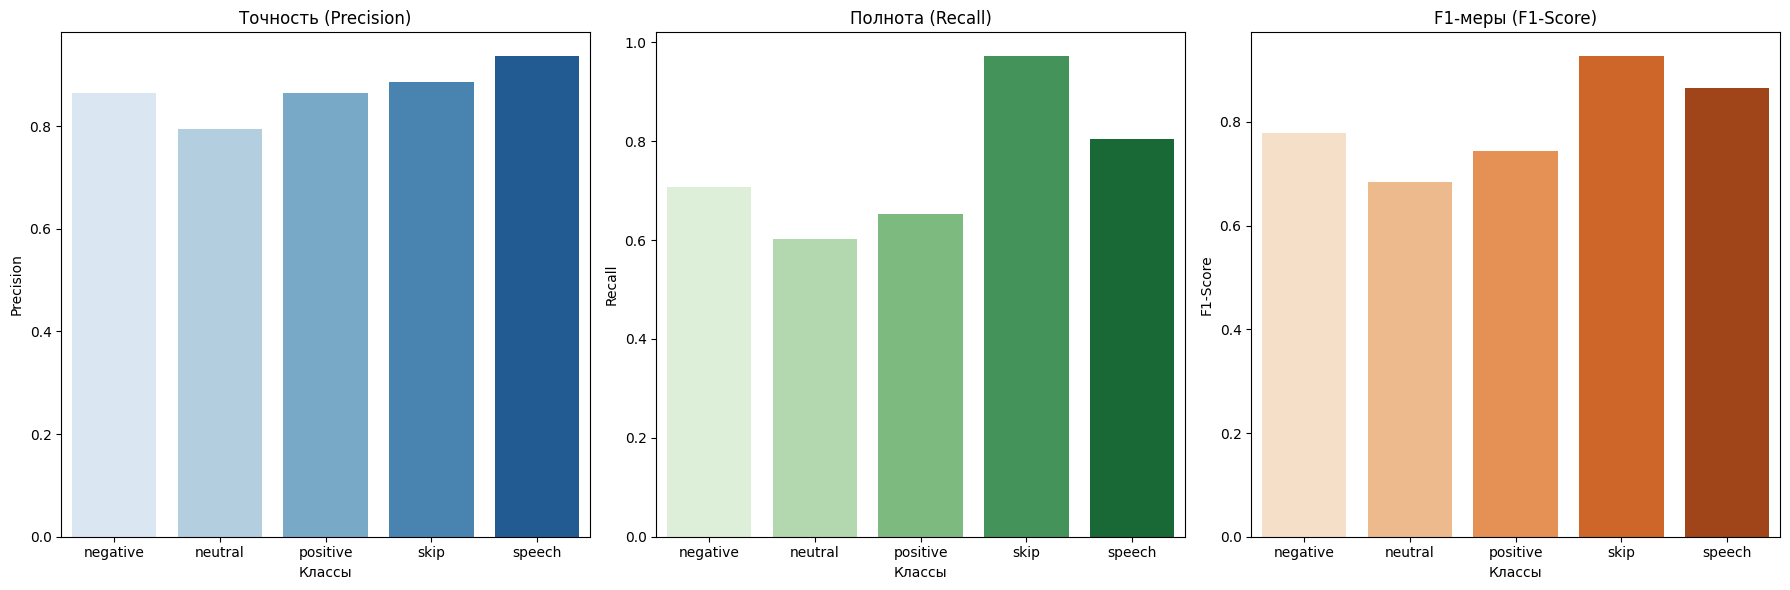

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(test_y_true_encoded, test_y_pred, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-3, :-1]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x=report_df.index, y=report_df['precision'], ax=axes[0], palette='Blues')
axes[0].set_title('Точность (Precision)')
axes[0].set_ylabel('Precision')
axes[0].set_xlabel('Классы')

sns.barplot(x=report_df.index, y=report_df['recall'], ax=axes[1], palette='Greens')
axes[1].set_title('Полнота (Recall)')
axes[1].set_ylabel('Recall')
axes[1].set_xlabel('Классы')

sns.barplot(x=report_df.index, y=report_df['f1-score'], ax=axes[2], palette='Oranges')
axes[2].set_title('F1-меры (F1-Score)')
axes[2].set_ylabel('F1-Score')
axes[2].set_xlabel('Классы')

plt.tight_layout()
plt.show()